# 1. Introduction and Problem Context

### 1. **Context**

Pneumonia is a leading cause of illness and death worldwide, often diagnosed through chest X-ray images. Healthy lungs typically appear dark, while pneumonia manifests as opacities ranging from grey to white. Detecting pneumonia can be particularly challenging even for experienced doctors due to factors like organ superposition (where pneumonia may be hidden by the heart or diaphragm), variations in thoracic representation influenced by age and sex, and the heterogeneous nature of pneumonia itself, which can affect multiple areas with varying shapes, forms, and sizes. In this study, we use the RSNA dataset, which includes classes for both healthy and pneumonia-affected thoraxes.

### 2. General Approach

Deep learning is applied for both classification and segmentation of chest X-ray images.

1. **Model (scheme below):**
The model has two inputs — image data (chest X-ray) and numerical data (patient features such as age and sex)—and two outputs: a segmentation mask and a binary target. Late fusion is applied to combine the inputs. We use a U-Net architecture with residual blocks, prioritizing segmentation over classification. To address class imbalance in the classification task, a personalized loss function is employed.

2. **Data Loading:**
We use a customized tf.data.Dataset to handle the two inputs and two outputs, ensuring efficient loading and preprocessing of the data for training.

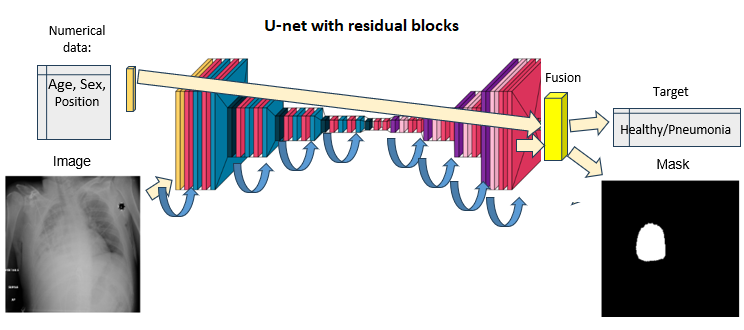

### **3. Results**


Results  on the test dataset show strong performance in both segmentation and classification tasks:

1. **Segmentation**
* IoU: 0.7077
  
2. **Classification:**
* Accuracy: 0.9315
* AUROC: 0.9785
* Precision: 0.9260
* Recall: 0.8949

# 2. Project Setup

## 2.1 Loading Packages

In [ ]:
import os, sys
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import keras
from PIL import Image
import matplotlib.pyplot as plt
import random

from tensorflow.keras.models import Model,Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Add, LeakyReLU,RandomFlip,RandomContrast,RandomBrightness, UpSampling2D,add, Input, Conv2D, Activation, Flatten, RandomRotation, RandomZoom, Dense, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, concatenate, Reshape, Conv2DTranspose
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam

from keras.metrics import BinaryIoU
from keras.utils import plot_model

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

random.seed(42)


from datasets import disable_progress_bar
disable_progress_bar()

## 2.2 Defining Useful Functions

In [ ]:
def visualize_predictions(dataset, model=None, num_samples=1, threshold=0.5):
    """
    Function to visualize images, ground truth masks, and predicted masks.

    Parameters:
    - model: The trained Keras model (optional).
    - dataset: The test dataset (tf.data.Dataset).
    - num_samples: The number of samples to display (default is 1).
    - threshold: Threshold to binarize the predicted mask (default is 0.5).
    """

    # Iterate through the specified number of samples
    for (image, var), (masks, targets) in dataset.take(1):  # Take only one batch
        for i in range(3, num_samples + 3):  # Iterate over each image in the batch

            # If a model is provided, make predictions
            if model is not None:
                pred_mask, pred_target = model.predict([image[i:i+1], var[i:i+1]])
                # Binarize the predicted mask using the threshold
                binarized_mask = (pred_mask[0] > threshold).astype(np.float32)  # Convert to binary
                show_pred = True  # Indicate that predictions should be displayed
            else:
                show_pred = False  # Do not display predictions

            # Convert the image to uint8 format for proper visualization
            img_to_show = (image[i].numpy() * 255).astype(np.uint8)

            # Visualize the images and both ground truth and predicted masks
            plt.figure(figsize=(10, 6))

            # Original image
            plt.subplot(1, 2 if not show_pred else 3, 1)
            plt.imshow(img_to_show)  # Display the image scaled to [0, 255]
            plt.title('Original Image')
            plt.axis('off')

            # Ground truth mask
            plt.subplot(1, 2 if not show_pred else 3, 2)
            plt.imshow(masks[i].numpy().squeeze(), cmap='gray')  # Ensure the mask is 2D
            plt.title('Ground Truth Mask')
            plt.axis('off')

            # Predicted binarized mask (only if a model is provided)
            if show_pred:
                plt.subplot(1, 3, 3)
                plt.imshow(binarized_mask.squeeze(), cmap='gray')  # Ensure the prediction is 2D
                plt.title('Predicted Mask (Binarized)')
                plt.axis('off')

            # Display the plot
            plt.tight_layout()
            plt.show()

            # Show the predicted binary target value (if a model is provided)
            if model is not None:
                print(f"Ground Truth Target: {targets[i].numpy()}, Predicted Target: {int(pred_target[0].item() > 0.5)}")
            else:
                print(f"Ground Truth Target: {targets[i].numpy()}, No model predictions available.")


In [ ]:
def plot_learning_curves(history):
    # Plot the loss
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Metrics for the binary target output
    plt.subplot(1, 3, 2)
    plt.plot(history['target_output_accuracy'], label='Training Accuracy')
    plt.plot(history['val_target_output_accuracy'], label='Validation Accuracy')
    plt.title('Binary Target Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0, 1)

    # IoU for the mask output
    plt.subplot(1, 3, 3)
    plt.plot(history.iloc[:, 1], label='Training IoU')
    plt.plot(history.iloc[:, 7], label='Validation IoU')
    plt.title('Mask IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.ylim(0, 1)

    plt.show()

# 3. Data Loading and Preprocessing(tf.Data.Dataset)

As our model is multi-input (image, tabular data) and multi-output (mask, target), we customize **tf.data.Dataset** to meet these requirements, including data loading, preprocessing, and batching.

**Tabular Data Preprocessing:**

*   Split into train, validation, and test sets.
*   Encode categorical features ('sex' and 'position').
*   Handle outliers by capping 'age' at a maximum of 90.
*   Scale 'age' to [0,1] using MinMaxScaler.
   
**Image Preprocessing:**

*   Resize images and masks.
*   Scale images to [0,1].
*   Apply data augmentation when specified.

## 3.1 Tabular data

Train, validation and test split:

In [ ]:
df = pd.read_csv('/kaggle/input/rsna-pneumonia-processed-dataset/stage2_train_metadata.csv')
df=df[df['class'].isin(["Lung Opacity","Normal"])].copy()
df.drop(['x', 'y', 'width', 'height','modality','class'],axis=1,inplace=True )
df= df.drop_duplicates()

df_train_val, df_test = train_test_split(df,test_size=0.1,stratify=df["Target"], random_state=42)
df_train, df_val = train_test_split(df_train_val,test_size=0.2,stratify=df_train_val["Target"], random_state=42)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(10700, 5)
(2676, 5)
(1487, 5)


Encode categorical features ('sex' and 'position').

Handle outliers: cap 'age' at a maximum of 90.

In [ ]:
# Mapping dictionaries
sex_mapping = {'M': 0, 'F': 1}
position_mapping = {'AP': 0, 'PA': 1}

# Apply the mapping to the corresponding columns
for df in [df_train, df_val, df_test]:
    df['sex'] = df['sex'].map(sex_mapping)
    df['position'] = df['position'].map(position_mapping)
    df['age'] = df['age'].apply(lambda x: 90 if x > 90 else x)

Scale 'age' to [0,1] using MinMaxScaler.

In [ ]:
scaler = MinMaxScaler()

# Fit the scaler to the 'age' column in the training set
df_train['age'] = scaler.fit_transform(df_train[['age']])

# Apply the same transformation to the validation and test sets
df_val['age'] = scaler.transform(df_val[['age']])
df_test['age'] = scaler.transform(df_test[['age']])

Result:

In [ ]:
df_train.describe()

,Target,age,sex,position
count,10700.000000,10700.000000,10700.000000,10700.000000
mean,0.404486,0.496994,0.435514,0.579907
std,0.490815,0.188205,0.495847,0.493597
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.359551,0.000000,0.000000
50%,0.000000,0.516854,0.000000,1.000000
75%,1.000000,0.640449,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_val.describe()

,Target,age,sex,position
count,2676.000000,2676.000000,2676.000000,2676.000000
mean,0.404709,0.493127,0.412930,0.563901
std,0.490927,0.189718,0.492452,0.495992
min,0.000000,0.011236,0.000000,0.000000
25%,0.000000,0.348315,0.000000,0.000000
50%,0.000000,0.505618,0.000000,1.000000
75%,1.000000,0.629213,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [ ]:
#For debugging
#batch_size = 1
#df_train_final=df_train.iloc[:2].copy()
#df_val_final=df_val.iloc[:2].copy()
#df_test_final=df_test.iloc[:2].copy()
#epochs =1
#steps_per_epoch =1
#validation_steps =1


df_train_final=df_train.copy()
df_val_final=df_val.copy()
df_test_final=df_test.copy()

batch_size = 64
epochs =10
steps_per_epoch =len(df_train_final)//batch_size
validation_steps =len(df_train_final)//batch_size

## 3.2 Image data

We define functions to load and preprocess images and masks with optional data augmentation. It will be used in the next section.

In [ ]:
image_size=224

def augment_image_and_mask(image, mask):
    # Adjust the brightness and contrast of the image
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, mask


# Function to load images and masks
def load_image_and_mask(image_path, mask_path, new_size=(224, 224), augmentation=0):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)

    # Resize the image and mask
    image = tf.image.resize(image, new_size)
    mask = tf.image.resize(mask, new_size)

    # Normalize the image
    image = tf.cast(image, tf.float32) / 255.0  # Escalar a [0, 1]

    # Normalize the binary mask
    mask = tf.cast(mask, tf.float32)
    mask = tf.where(mask > 0, 1.0, 0.0)  # Convertir valores a 0 y 1

    # Apply data augmentation if the parameter is set to 1
    if augmentation == 1:
        image, mask = augment_image_and_mask(image, mask)

    return image, mask

## 3.3 Customized Dataset

As our model is multi-input (image, tabular data) and multi-output (mask, target), we customize tf.data.Dataset to meet these requirements, including data loading, preprocessing, and batching.

In [ ]:
# Working and input directories
output_dir = "/kaggle/working/"
input_dir = "/kaggle/input/rsna-pneumonia-processed-dataset/"
images_dir = input_dir + "Training/" + 'Images/'  # Directory containing images
mask_dir = input_dir + "Training/" + 'Masks/'    # Directory containing masks

# Dictionaries to store results for each dataset
image_paths = {}      # Dictionary to store image paths
mask_paths = {}       # Dictionary to store mask paths
variables_num = {}    # Dictionary to store numerical variables
target = {}           # Dictionary to store target labels

# List of datasets (train, validation, test)
datasets = [
    ('train', df_train_final),  # Training dataset
    ('val', df_val_final),      # Validation dataset
    ('test', df_test_final)     # Test dataset
]

# Loop through each dataset and populate the dictionaries
for name, df in datasets:
    # Store image paths: concatenate directory with patientId
    image_paths[name] = images_dir + df["patientId"].astype(str) + ".png"

    # Store mask paths: concatenate directory with patientId
    mask_paths[name] = mask_dir + df["patientId"].astype(str)+ ".png"

    # Store numerical variables: extract 'age', 'sex', and 'position' columns
    variables_num[name] = df[["age", "sex", "position"]].values

    # Store target values: extract the 'Target' column
    target[name] = df['Target'].values

# Verify results
print(image_paths['train'].head())  # Display the first few image paths for training set
print(variables_num['val'][:5])     # Display the first 5 numerical variable rows for validation set
print(target['test'][:5])           # Display the first 5 target values for test set


9879    /kaggle/input/rsna-pneumonia-processed-dataset...
8415    /kaggle/input/rsna-pneumonia-processed-dataset...
9191    /kaggle/input/rsna-pneumonia-processed-dataset...
2134    /kaggle/input/rsna-pneumonia-processed-dataset...
762     /kaggle/input/rsna-pneumonia-processed-dataset...
Name: patientId, dtype: object
[[0.46067416 0.         0.        ]
 [0.33707865 0.         0.        ]
 [0.62921348 0.         0.        ]
 [0.28089888 0.         1.        ]
 [0.5505618  1.         0.        ]]
[0 0 0 0 1]


In [ ]:
def create_dataset(image_paths, mask_paths, variables_num, target, batch_size, augmentation=0, shuffle=False, repeat=False):
    # Load paths, numerical variables, and target values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths, variables_num, target))

    # Map function to load and preprocess the data
    dataset = dataset.map(lambda img_path, mask_path, var, tgt:
                          ((load_image_and_mask(img_path, mask_path, augmentation=augmentation)[0], var),  # Input: image and variables
                           (load_image_and_mask(img_path, mask_path, augmentation=augmentation)[1], tgt)))  # Output: mask and target

    # Shuffle only if specified
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    # Repeat if specified
    if repeat:
        dataset = dataset.repeat()  # Repeat indefinitely

    # Batch and optimize
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Create datasets
train_dataset = create_dataset(image_paths['train'], mask_paths['train'], variables_num['train'],
                               target['train'], batch_size, augmentation=1, shuffle=True, repeat=True)  # Shuffle enabled and repeat
val_dataset = create_dataset(image_paths['val'], mask_paths['val'], variables_num['val'],
                             target['val'], batch_size, shuffle=False, repeat=True)  # No shuffle, no repeat
test_dataset = create_dataset(image_paths['test'], mask_paths['test'], variables_num['test'],
                              target['test'], batch_size, shuffle=False)  # No shuffle, no repeat


In [ ]:
for batch in train_dataset.take(1):
    (images, variables), (masks, targets) = batch
    print("Images shape:", images.shape)
    print("Variables shape:", variables.shape)
    print("Masks shape:", masks.shape)
    print("Targets shape:", targets.shape)

Images shape: (64, 224, 224, 3)
Variables shape: (64, 3)
Masks shape: (64, 224, 224, 1)
Targets shape: (64,)


# 4. EDA

**Key Findings**
* Image Visualization: Pneumonia-affected areas appear in white on the mask, while healthy chest masks are completely black.
* Target Imbalance: The dataset is imbalanced, requiring a custom loss function to give more weight to the minority class.

## 4.1 Image Visualization

We visualize chest X-ray images and their masks to understand the dataset.

* Example 1: A healthy case with no affected areas in the mask.
* Example 2: A pneumonia case, with the mask highlighting the affected region in white.

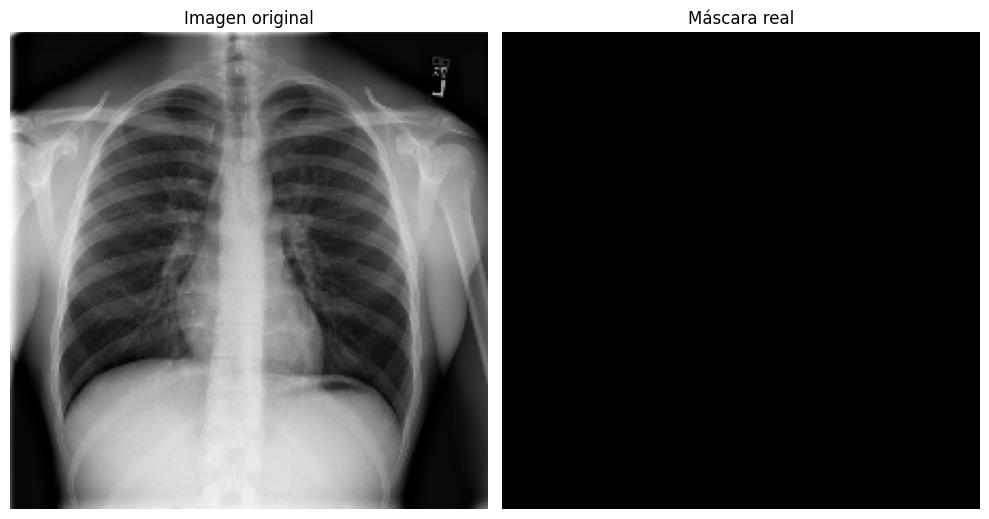

Target real: 0, No hay predicción del modelo.


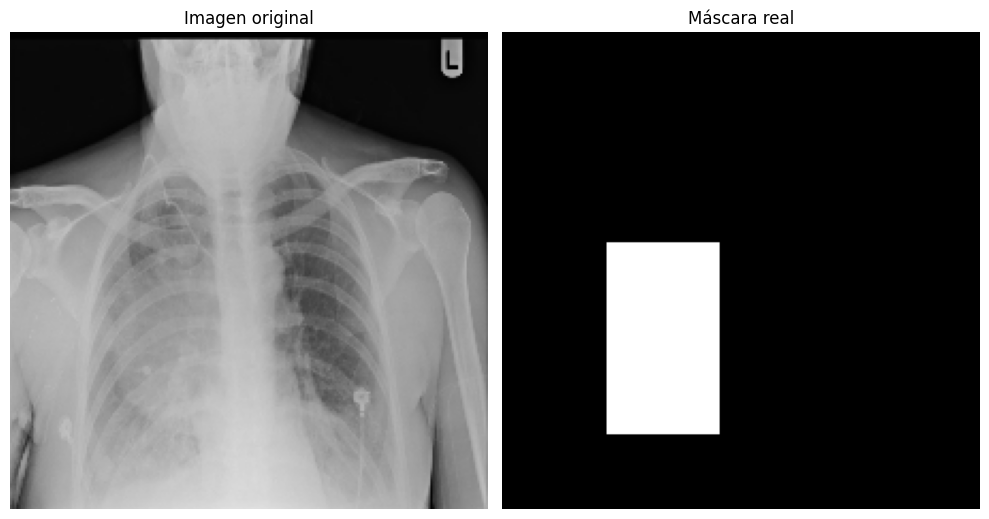

Target real: 1, No hay predicción del modelo.


In [ ]:
visualize_predictions(dataset=val_dataset, num_samples=2)

## 4.2 Class Distribution

The target classes are imbalanced, which may negatively impact model training. To address this, we will define a custom loss function to assign greater weight to the minority class.

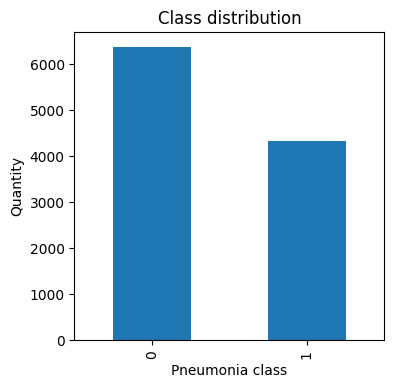

In [ ]:
plt.figure(figsize=(4,4))
df_train_final["Target"].value_counts().plot(kind="bar")
plt.title("Class distribution")
plt.xlabel("Pneumonia class")
plt.ylabel("Quantity")
plt.show()

# 5. Model

## 5.1. Building Model.

We use a U-Net architecture with two inputs (image and numerical data) and two outputs (mask and target). The model has a depth of 4 convolutional blocks, incorporating skip connections and residual blocks. Leaky ReLU activation is used to avoid the issue of dead neurons.

In [ ]:
from tensorflow.keras.layers import LeakyReLU
def residual_block_leaky(input, n_filters):
    res = BatchNormalization()(input)
    res = Conv2D(n_filters, (3, 3), padding='same', use_bias=False)(res)
    res = BatchNormalization()(res)
    res = LeakyReLU(negative_slope=0.1)(res)
    res = Conv2D(n_filters, (3, 3), padding='same', use_bias=False)(res)
    res = BatchNormalization()(res)
    res = Add()([res, input])
    res = LeakyReLU(negative_slope=0.1)(res)
    return res

In [ ]:
def unet_hybrid():
    input_im = Input(shape=(image_size, image_size, 3))
    var_input = Input(shape=(3,))

    # Encoder with residual blocks
    conv0 = Conv2D(32, (3, 3), padding='same', use_bias=False)(input_im)
    conv0 = BatchNormalization()(conv0)
    conv0 = LeakyReLU(negative_slope=0.1)(conv0)

    conv1 = Conv2D(32, (3, 3), padding='same', use_bias=False)(conv0)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(negative_slope=0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    res1 = residual_block_leaky(pool1, 32)

    conv2 = Conv2D(64, (3, 3), padding='same', use_bias=False)(res1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(negative_slope=0.1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)
    res2 = residual_block_leaky(pool2, 64)

    conv3 = Conv2D(128, (3, 3), padding='same', use_bias=False)(res2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(negative_slope=0.1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)
    res3 = residual_block_leaky(pool3, 128)

    conv4 = Conv2D(256, (3, 3), padding='same', use_bias=False)(res3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(negative_slope=0.1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv4)
    res4 = residual_block_leaky(pool4, 256)

    # Bottleneck
    conv5 = Conv2D(512, (3, 3), padding='same', use_bias=False)(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(negative_slope=0.1)(conv5)
    conv5 = Conv2D(512, (3, 3), padding='same', use_bias=False)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(negative_slope=0.1)(conv5)
    drop5 = Dropout(0.3)(conv5)

    # Decoder with residual blocks
    up6 = Conv2DTranspose(256, kernel_size=(2, 2), strides=2, padding='same', use_bias=False)(drop5)
    up6 = BatchNormalization()(up6)
    up6 = LeakyReLU(negative_slope=0.1)(up6)
    merge6 = concatenate([conv4, up6], axis=3)
    res6 = residual_block_leaky(merge6, 512)

    up7 = Conv2DTranspose(128, kernel_size=(2, 2), strides=2, padding='same', use_bias=False)(res6)
    up7 = BatchNormalization()(up7)
    up7 = LeakyReLU(negative_slope=0.1)(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    res7 = residual_block_leaky(merge7, 256)

    up8 = Conv2DTranspose(64, kernel_size=(2, 2), strides=2, padding='same', use_bias=False)(res7)
    up8 = BatchNormalization()(up8)
    up8 = LeakyReLU(negative_slope=0.1)(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    res8 = residual_block_leaky(merge8, 128)

    up9 = Conv2DTranspose(32, kernel_size=(2, 2), strides=2, padding='same', use_bias=False)(res8)
    up9 = BatchNormalization()(up9)
    up9 = LeakyReLU(negative_slope=0.1)(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    res9 = residual_block_leaky(merge9, 64)

    # Process numeric variables
    var_dense = Dense(64, activation='relu')(var_input)  # Capa densa para las variables adicionales
    var_dense = BatchNormalization(momentum=0.9)(var_dense)
    var_reshaped = Reshape((1, 1, 64))(var_dense)
    var_reshaped = UpSampling2D(size=(image_size // 1, image_size // 1))(var_reshaped)  # Ajustar a 224x224

    # Merged output
    merged_output = concatenate([res9, var_reshaped], axis=-1)

    # Output for segmentation
    mask_output = Conv2D(1, (1, 1), activation='sigmoid', name="mask_output")(merged_output)

    # Output for classification
    flatten = GlobalAveragePooling2D()(merged_output)
    dense = Dense(64, use_bias=False)(flatten)
    dense = BatchNormalization()(dense)
    dense = LeakyReLU(negative_slope=0.1)(dense)
    target_output = Dense(1, activation='sigmoid', name='target_output')(dense)

    # Create model with 2 inputs and 2 outputs
    model = Model(inputs=[input_im, var_input], outputs=[mask_output, target_output])

    return model


model = unet_hybrid()
#model.summary()
#keras.utils.plot_model(model, show_shapes=True)

## 5.2. Callbacks: EarlyStopping & ReduceLROnPlateau

We use the EarlyStopping callback to prevent overfitting and the ReduceLROnPlateau callback to dynamically adjust the learning rate when the validation loss stops improving

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              min_lr=1e-8)


 ## 5.3 Class weights

We define class weights to use within the custom loss function. While class weights are typically applied directly during model training to address class imbalance, this approach does not work for models with two outputs, as in our case.

In [ ]:
y = df_train["Target"]
classes = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
class_weights_dict

{0: 0.8396107972379159, 1: 1.2361367837338262}

## 5.4 Loss functions

To address class imbalance, we define a custom loss function based on weighted binary crossentropy. This function adjusts the loss by applying class-specific weights, giving more importance to the minority class.

In [ ]:

def weighted_binary_crossentropy(class_weights):
    def loss_fn(y_true, y_pred):
        # Ensure the weights are float32
        class_weights_cast = [tf.cast(class_weights[0], tf.float32), tf.cast(class_weights[1], tf.float32)]

        # Apply weights directly based on the classes
        weights = tf.where(tf.equal(y_true, 1), class_weights_cast[1], class_weights_cast[0])

        # Compute standard Binary Crossentropy
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

        # Adjust the loss based on the weight
        return bce * weights

    return loss_fn


In [ ]:
def iou_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return 1 - (intersection + 1e-6) / (union + 1e-6)

## 5.5 Model Training and Evaluation

### The model is trained using the following **hyperparameters:**
1. Optimizer: Adam with a learning rate of 0.001.
2. Loss Functions:
* Mask Output: IoU loss.
* Target Output: Weighted binary crossentropy to address class imbalance.
3. Metrics:
* Mask Output: Binary IoU.
* Target Output: Accuracy, precision, recall, and AUC.
4. Loss Weights:
* Mask output: 0.7
* Target output: 0.3
5. Callbacks: Early stopping and learning rate reduction to prevent overfitting and improve performance.

### **Results of Training:**

The model has converged with the following validation performance:

* Validation Mask Output Binary IoU: 0.4684
* Validation Target Output Accuracy: 0.9421
* Validation Target Output Recall: 0.9106
These results indicate strong performance, especially in terms of classification accuracy and recall, while the segmentation (IoU) is improving.

In [ ]:

learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              #loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              loss={'mask_output': iou_loss,
                    'target_output': weighted_binary_crossentropy(class_weights_dict)},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]},
              loss_weights={'mask_output': 0.7, 'target_output': 0.3})


history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, reduce_lr])


model.save(output_dir  + 'model_unet.keras')


history_df = pd.DataFrame(history.history)
history_df.to_csv(output_dir + 'history_unet.csv', index=False)

Epoch 1/10


I0000 00:00:1734511003.158734     493 service.cc:145] XLA service 0x7c4b480022d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734511003.158790     493 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734511003.158796     493 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-12-18 08:37:15.612637: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,128,112,112]{3,2,1,0}, f32[128,32,2,2]{3,2,1,0}), window={size=2x2 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-18 08:37:16.488020: E external/local_xla/x

167/167 ━━━━━━━━━━━━━━━━━━━━ 563s 2s/step - loss: 0.7299 - mask_output_binary_io_u: 0.3404 - target_output_accuracy: 0.7751 - target_output_auroc: 0.8382 - target_output_precision: 0.7290 - target_output_recall: 0.7377 - val_loss: 26.8724 - val_mask_output_binary_io_u: 0.4985 - val_target_output_accuracy: 0.4046 - val_target_output_auroc: 0.5000 - val_target_output_precision: 0.4046 - val_target_output_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - loss: 0.5642 - mask_output_binary_io_u: 0.4615 - target_output_accuracy: 0.8709 - target_output_auroc: 0.9283 - target_output_precision: 0.8854 - target_output_recall: 0.7844 - val_loss: 0.6466 - val_mask_output_binary_io_u: 0.3593 - val_target_output_accuracy: 0.8353 - val_target_output_auroc: 0.9233 - val_target_output_precision: 0.9611 - val_target_output_recall: 0.6178 - learning_rate: 0.0010
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - loss: 0.5091 - mask_output_binary_io_u: 0.507

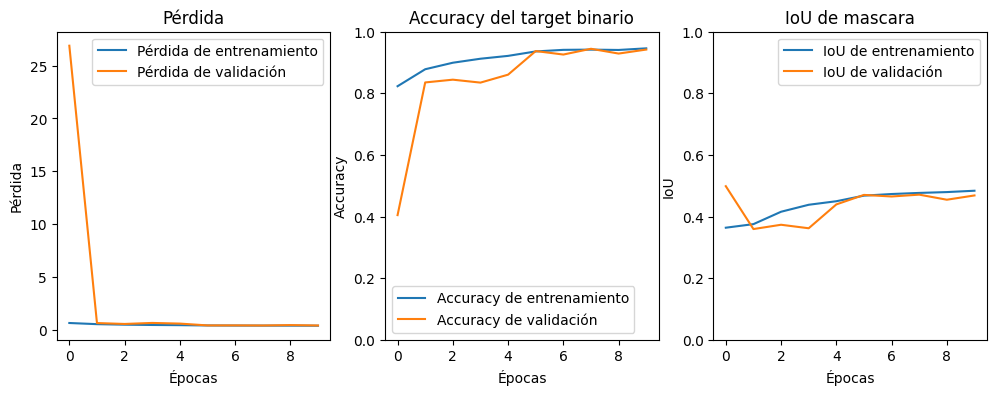

In [ ]:
history_df_csv=pd.read_csv(output_dir + 'history_unet.csv')
plot_learning_curves(history_df_csv)

# 6. Inference and Evaluation

The model was evaluated on the test dataset, and the results show strong performance in both segmentation and classification tasks:

1. **Segmentation**
* IoU: 0.7077
  
2. **Classification:**
* Accuracy: 0.9315
* AUROC: 0.9785
* Precision: 0.9260
* Recall: 0.8949

In [ ]:
model.evaluate(test_dataset)

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 492ms/step - loss: 0.4121 - mask_output_binary_io_u: 0.7077 - target_output_accuracy: 0.9315 - target_output_auroc: 0.9785 - target_output_precision: 0.9260 - target_output_recall: 0.8949


[0.4115723669528961,
 0.6811110377311707,
 0.9361129999160767,
 0.9787561893463135,
 0.9332191944122314,
 0.9068219661712646]

## 6.1 Predictions on Test Data

In [ ]:
class_names = ['Healthy','Pneumonia']

In [ ]:
# Get the true classes (ground truth) from the test generator
true_classes = []

# Iterate over the test dataset
for (_, _),( _, target) in test_dataset:
    true_classes.append(target.numpy())  # Append each batch of target values

# Convert the list of true classes to a numpy array
true_classes = np.concatenate(true_classes, axis=0)

In [ ]:
# Get predictions from the model(probabilities of class 1)

predicted_mask_prob, predicted_classes_prob = model.predict(test_dataset)

# Convert predicted probabilities for the mask to binary values (0 or 1) using a threshold of 0.5
predicted_mask = (predicted_mask_prob > 0.5).astype(int)

# Convert predicted probabilities for the target classes to binary values (0 or 1) using a threshold of 0.5
predicted_classes_list = (predicted_classes_prob > 0.5).astype(int)
predicted_classes=np.concatenate(predicted_classes_list, axis=0)

24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step 


## 6.2 Classification Report

In [ ]:
# Generate the classification report
# target_names assigns human-readable class names from the test generator
report = classification_report(true_classes, predicted_classes,target_names=class_names)
print(report)


              precision    recall  f1-score   support

     Healthy       0.94      0.96      0.95       886
   Pneumonia       0.93      0.91      0.92       601

    accuracy                           0.94      1487
   macro avg       0.94      0.93      0.93      1487
weighted avg       0.94      0.94      0.94      1487



## 6.3 Confusion Matrix

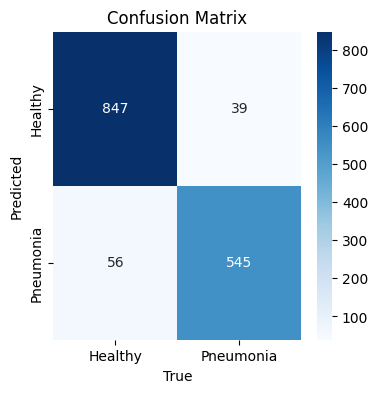

In [ ]:
plt.figure(figsize=(4,4))
cm=confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d',cmap="Blues", xticklabels=class_names,yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

## 6.4. Visualization: True vs Predicted Masks

Shown from left to right: the image, real mask (ground truth), and predicted mask for the test data.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


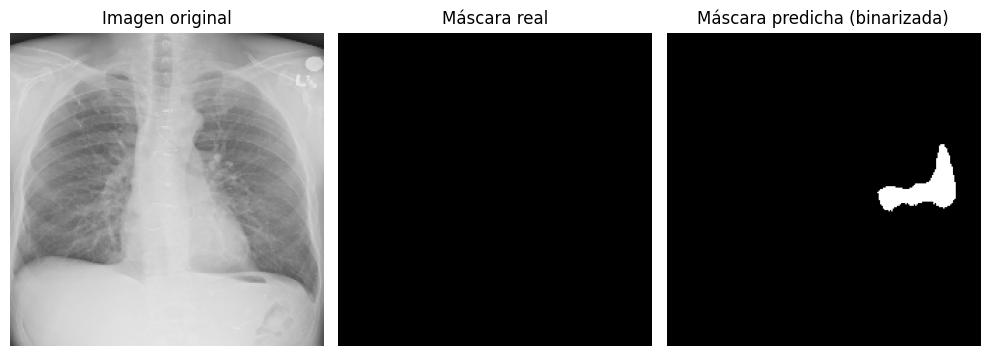

Target real: 0, Target predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


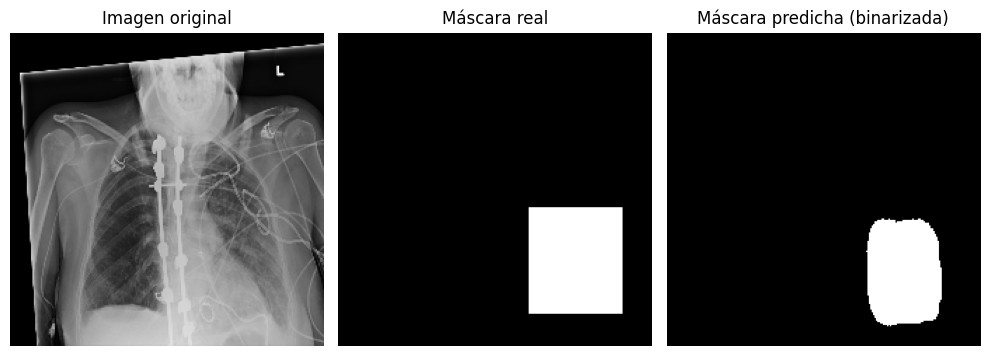

Target real: 1, Target predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


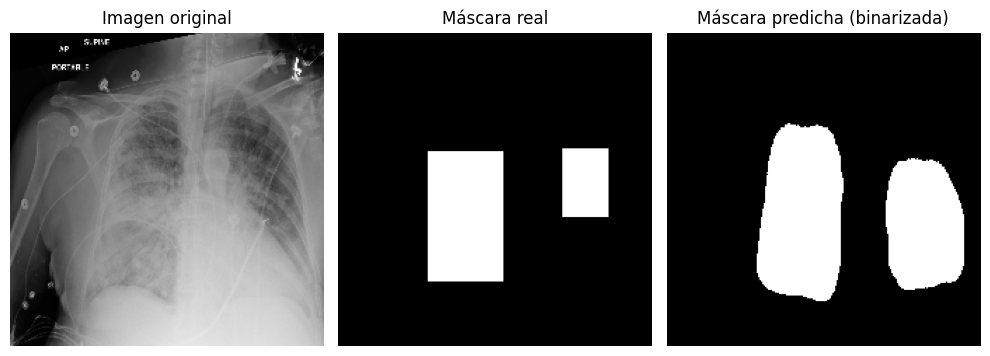

Target real: 1, Target predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


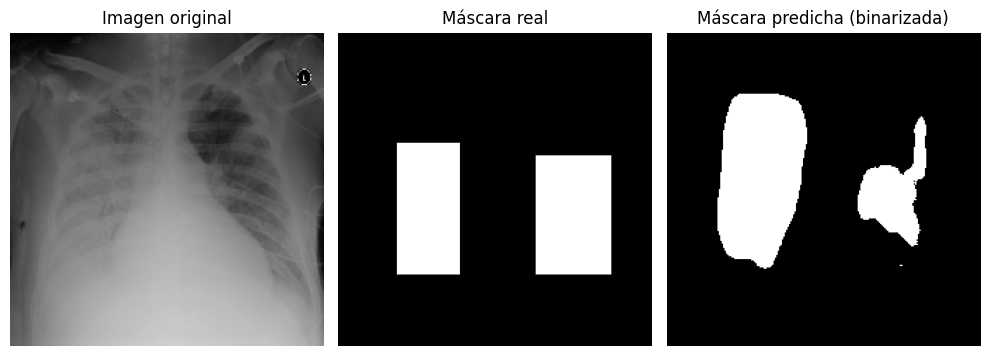

Target real: 1, Target predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


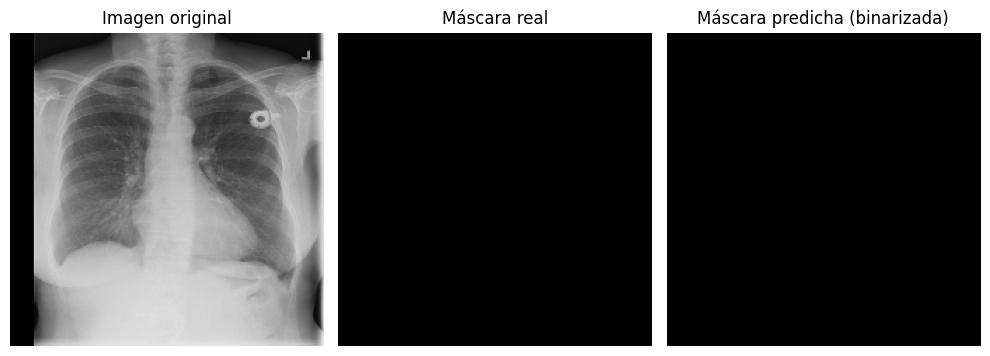

Target real: 0, Target predicho: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


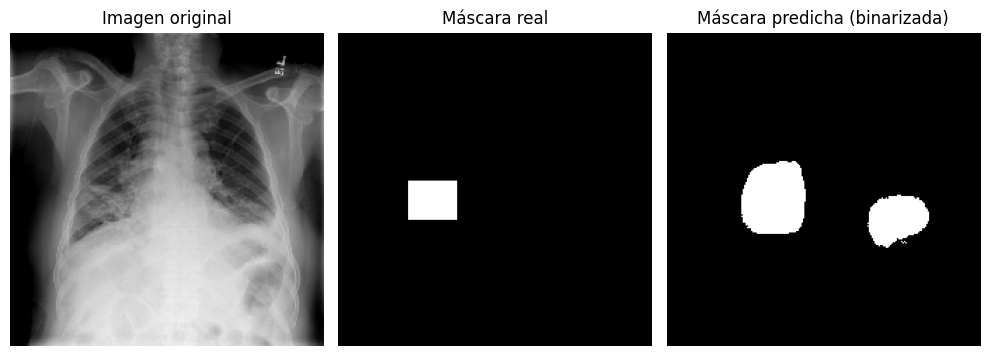

Target real: 1, Target predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


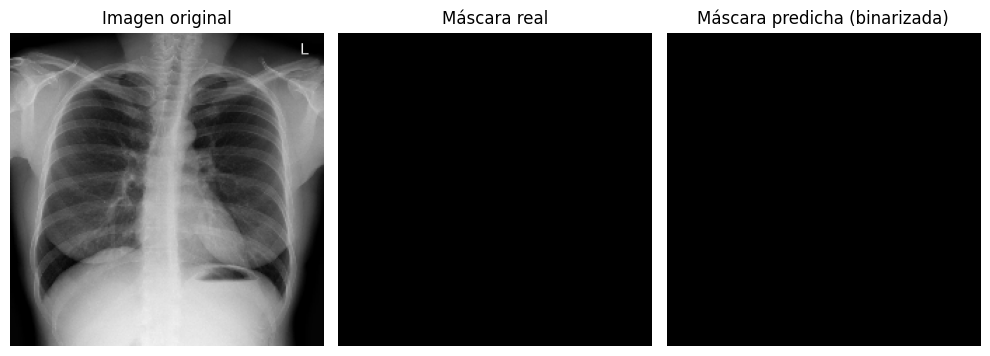

Target real: 0, Target predicho: 0


In [ ]:
visualize_predictions(dataset=test_dataset, model=model, num_samples=7)